## SARS-CoV2 Genome Analysis

In [1]:
from Bio import Entrez
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import AlignIO

import os
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import re

In [2]:
# # Download sequences
# Entrez.email = ""

# get accension numbers
# with Entrez.esearch(db="nucleotide", term="SARS-CoV-2[ORGN]", idtype="acc", retmax="500") as handle:
#     results = Entrez.read(handle)
#     acc_nums = results["IdList"]
    
# #Use efetch to download records and save to disk
# filename = "C:/..../.../filename"
# if not os.path.isfile(filename):
#     # Downloading...
#     with Entrez.efetch(db="nucleotide", id=acc_nums, rettype="gb", retmode="text") as net_handle: 
#         with open(filename, "w") as out_handle:
#             out_handle.write(net_handle.read())
#     print("Saved")

In [3]:
# retreive first sequence from file
data = next(SeqIO.parse('sarscov2_sequence_data', format='gb'))

# count nucleotides
nucleo_count = collections.Counter(data.seq)

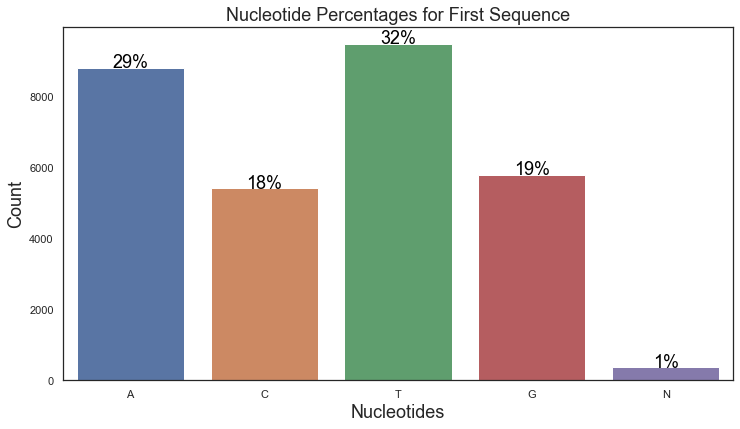

In [4]:
# count nucleotides and get percentage of each
nucleo_count = collections.Counter(data.seq)
x = list(nucleo_count.keys())
y = list(nucleo_count.values())
percent = [round(j/len(data.seq)*100) for j in y]

# plot
sns.set(style="white")
fig, ax = plt.subplots(figsize=(12,6.5))
sns.barplot(x=x, y=y)
plt.xlabel('Nucleotides', fontsize='18')
plt.ylabel('Count', fontsize='18')
plt.title('Nucleotide Percentages for First Sequence', fontsize='18')

plt.text(x=0, y=y[0], s='{}%'.format(percent[0]), 
                 color='black', fontsize=18, horizontalalignment='center')
plt.text(x=1, y=y[1], s='{}%'.format(percent[1]), 
                 color='black', fontsize=18, horizontalalignment='center')
plt.text(x=2, y=y[2], s='{}%'.format(percent[2]), 
                 color='black', fontsize=18, horizontalalignment='center')
plt.text(x=3, y=y[3], s='{}%'.format(percent[3]), 
                 color='black', fontsize=18, horizontalalignment='center')
plt.text(x=4, y=y[4], s='{}%'.format(percent[4]), 
                 color='black', fontsize=18, horizontalalignment='center');

In [5]:
# transcribe to mRNA
data_transcribed = data.seq.transcribe()

# translate to amino acid sequence
amino_seq = data_transcribed.translate()

# split amino acids at stop codons
proteins = amino_seq.split("*")

"SARS-CoV-2 has a single-stranded positive-sense RNA genome that codes for 10 genes ultimately producing 26 proteins according to an NCBI annotation (NC_045512)."

In [6]:
# create dataframe for sorting
lst = []

for p in proteins:
    lst.append([len(p), str(p)])
    
df = pd.DataFrame(lst, columns=['length', 'sequence'])

# remove smaller proteins
proteins_to_remove = df.sort_values('length', ascending=False)[5:].index.values

remove_list = []
for i in proteins_to_remove:
    remove_list.append(proteins[i])
    
for i in remove_list:
    proteins.remove(i)

The largest protein is around 4400. orf1ab encodes a polyprotein that is cleaved into 16 proteins by proteases that are themselves part of the polyprotein. Perhaps this long protein is produced from orf1ab.

In [7]:
# get coding regions.
orf = []
for strand, nuc in [(+1, data.seq), (-1, data.seq.reverse_complement())]:
    for frame in range(3):
        for pro in nuc[frame:].translate(table=1).split("*"):
            if len(pro) >= 200:
                orf.append((len(pro), pro))

orf

C:\Users\Chris\anaconda3\lib\site-packages\Bio\Seq.py:2334: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


[(4409, Seq('PKGKMESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGT...FAV')),
 (1293, Seq('LEKTTELLFLVMFLLTTKRTMFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTR...HYT')),
 (433, Seq('RSCCFRFHLNEQTKMSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQR...TQA')),
 (243, Seq('SSGLNELNIILVFLFGTLILAMADSNGTITVEELKKLLEQWNLVIGFLFLTWIC...LVQ')),
 (2701, Seq('CTIVFKRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNCCRFQ...VNN')),
 (290, Seq('ASAQRSQITLHINELMDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQA...VPL'))]

The first many results from the BLAST will be from SARS-CoV-2, but we can check the closest related proteins from other organisms and how closely they match. The percent matches will vary.

In [8]:
# Results from blast.
info = {'Protein' : ['PP1a (ORF1a Polyprotein)', 'S Glycoprotein (Spike)', 'Nucleocapsid Phosphoprotein', 'Membrane (M) Protein', 'PP1ab (ORF1ab Polyprotein)', 'ORF3a Protein'],
        'Length' : ['4409', '1293', '433', '243', '2701', '290'],
        'Function' : ['Polyprotein that undergoes proteolytic processing to form 11 proteins involved in replication/transcription',
                      'Membrane fusion is mediated by this protein with ACE2 receptors on the surface of host cells',
                      'Responsible for viral RNA packaging',
                      'Glycosylated structural protein essential for the assembly of viral particles',
                      'Polyprotein that undergoes proteolytic processing to form 16 proteins involved in replication/transcription',
                      'Forms potassium ion channels and may modulate virus release.'],
        'Closest Organism Match' : ['SARS-CoV', 'SARS-CoV', 'SARS-CoV', 'Bat coronavirus Rp3/2004', 'SARS-CoV', 'Bat coronavirus Rp3/2004'],
        'Match %': [80, 76, 91, 92, 96, 95]
       }

# produce table
orf_df = pd.DataFrame(data=info)
orf_df.sort_values('Match %', ascending=False).style.background_gradient()

,Protein,Length,Function,Closest Organism Match,Match %
4,PP1ab (ORF1ab Polyprotein),2701,Polyprotein that undergoes proteolytic processing to form 16 proteins involved in replication/transcription,SARS-CoV,96
5,ORF3a Protein,290,Forms potassium ion channels and may modulate virus release.,Bat coronavirus Rp3/2004,95
3,Membrane (M) Protein,243,Glycosylated structural protein essential for the assembly of viral particles,Bat coronavirus Rp3/2004,92
2,Nucleocapsid Phosphoprotein,433,Responsible for viral RNA packaging,SARS-CoV,91
0,PP1a (ORF1a Polyprotein),4409,Polyprotein that undergoes proteolytic processing to form 11 proteins involved in replication/transcription,SARS-CoV,80
1,S Glycoprotein (Spike),1293,Membrane fusion is mediated by this protein with ACE2 receptors on the surface of host cells,SARS-CoV,76


# Finding Mutations between sequences

First we have to pad the sequences be the same length so we can plot them.

In [9]:
# read file
record = list(SeqIO.parse('sarscov2_sequence_data', format='gb'))

In [10]:
# find longest seq length
longest_length = 0
for i in range(len(record)):
    length = len(record[i].seq)
    if length > longest_length:
        longest_length = length
    else:
        continue
print('The longest sequence is {} bases long.'.format(longest_length))

The longest sequence is 29906 bases long.


The longest sequence is 29906 so for simplicity I will pad the sequences to be 30000 bases long. Below is a function to pad them. 

In [11]:
# input should Biopython Seq object, return is numpy array
def increase_seq_length(seq, end_length=30000, return_type=None): 
    
    start_length = len(seq)
    numpy_seq = np.array(seq)
    amount_to_add = end_length - start_length
    return_type = return_type
    
    if start_length == end_length:
        
        if return_type == 'bioseq':
            return Seq(''.join(numpy_seq))
        
        elif return_type == 'array':
            return numpy_seq
    
    elif start_length < end_length:
        numpy_seq = np.append(numpy_seq, np.repeat('N', amount_to_add))
        
        if return_type == 'bioseq':
            return Seq(''.join(numpy_seq))
        
        elif return_type == 'array':
            return numpy_seq

In [12]:
# pad sequences
for i in range(len(record)):
    try:
        record[i].seq = increase_seq_length(record[i], end_length=30000, return_type='bioseq')
    except:
        print(i)
        continue

In [13]:
# dictionary to map to sequences
dic = {'A': 0,
       'T': 255,
       'C': 100,
       'G': 200,
       'N': 75}

# get two sequences
seq1 = record[1].seq[:]
seq2 = record[2].seq[:]

# map dictionary
seq1_values = np.array([dic[letter] for letter in seq1])
seq2_values = np.array([dic[letter] for letter in seq2])

# find "mutations"
mutations = seq1_values - seq2_values
for i in np.where(mutations != 0)[0]:
    mutations[i] = 50
    print('Difference between sequences at position {}'.format(i))

Difference between sequences at position 1100
Difference between sequences at position 7225
Difference between sequences at position 8981
Difference between sequences at position 11082
Difference between sequences at position 12686
Difference between sequences at position 17689
Difference between sequences at position 20347
Difference between sequences at position 25426
Difference between sequences at position 29782


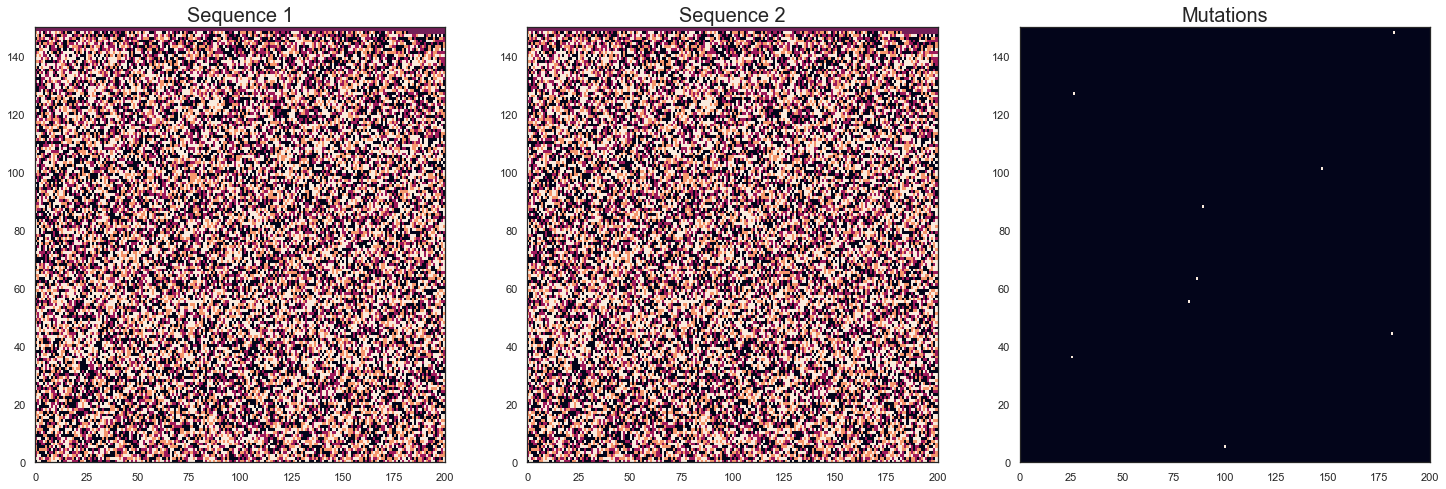

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))

ax0.pcolor(np.reshape(seq1_values, (150, 200))) 
ax1.pcolor(np.reshape(seq2_values, (150, 200))) 
ax2.pcolor(np.reshape(mutations, (150, 200)))

ax0.set_title('Sequence 1', fontsize=20)
ax1.set_title('Sequence 2', fontsize=20)
ax2.set_title('Mutations', fontsize=20);

We have found the mutations between two viral genomes, but are they in coding regions? If they are in coding regions, do they produce different codons? Does this new codon produce a different amino acid? Does this amino acid result in a structural change to the protein? Does that structural change produce a phenotypic change? Is this phenotypic change relavent to the clinical pathology of the disease?

A mutation in a genome more often than not does nothing, and when it does produce a phenotypic change, it isn't likely to be advantagous. However, we have seen several SARS-CoV2 variants appear to be more easily spread. Some variants even appear to be less susceptible to bamlanivimab, a monoclonal antibody directed against the SARS-CoV-2 spike protein.